In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# First two returns are just the full dataset X and y
# Next two are the edited dataset using G_avg and dropped highly correlated inputs
# Last two are an edited dataset using G_avg and only the six highest correlating inputs
def load_math_dataset():
    full_dataset = pd.read_csv("Math-Students.csv", sep=",")

    # Create dataset with all data for testing
    fData_X = full_dataset.drop("G3", axis=1)
    fData_y = full_dataset["G3"]
    fData_X = pd.get_dummies(fData_X, drop_first=False)  # one-hot encode categorical features

    # Change output label to average of grades
    grades = ['G1', 'G2', 'G3']
    full_dataset['G_avg'] = full_dataset[grades].mean(axis=1)
    full_dataset = full_dataset.drop(columns=grades)

    # Split X and y for complex dataset (all non-correlated features)
    correlation_drop = ['Dalc', 'Walc', 'Fedu']
    complex_dataset = full_dataset.drop(columns=correlation_drop)
    cData_X = complex_dataset.drop("G_avg", axis=1)
    cData_y = complex_dataset["G_avg"]
    cData_X = pd.get_dummies(cData_X, drop_first=False)  # one-hot encode categorical features

    # Split X and y for simple dataset (only features with highest G_avg correlation)
    best_features = ['failures', 'Medu', 'goout', 'age', 'studytime', 'traveltime']
    simple_dataset = complex_dataset[best_features + ['G_avg']]
    sData_X = simple_dataset.drop("G_avg", axis=1)
    sData_y = simple_dataset["G_avg"]
    sData_X = pd.get_dummies(sData_X, drop_first=False)  # one-hot encode categorical features

    return fData_X, fData_y, cData_X, cData_y, sData_X, sData_y

Best parameters: {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Test MSE: 11.2714
R^2 Score: 0.1353


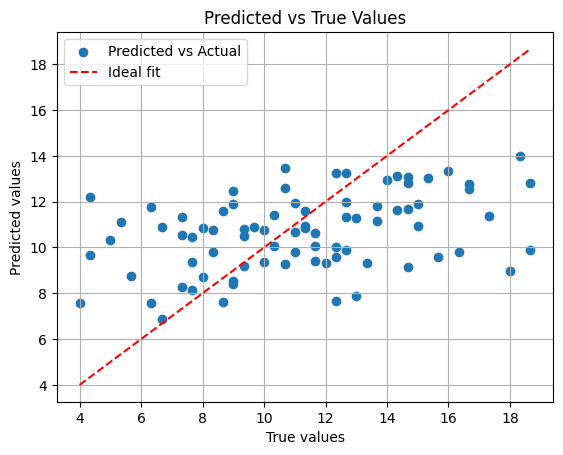

In [5]:
# Regression predicting G_avg (remove correlated inputs)
_, _, cData_X, cData_y, _, _ = load_math_dataset()
X_train, X_test, y_train, y_test = train_test_split(cData_X, cData_y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.9, 0.8, 0.7]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

rf = RandomForestRegressor(random_state=42)
rf.set_params(**grid_search.best_params_)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.scatter(y_test, y_pred, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid(True)
plt.show()

Best params: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1000}

Test MSE: 2.9641
R^2 Score: 0.8565


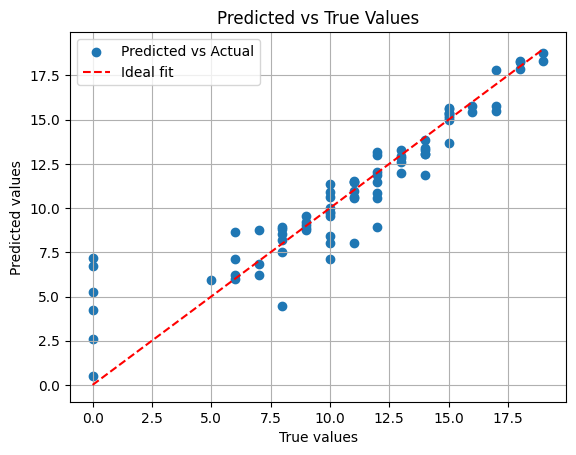

In [7]:
# Regression predicting G3 using all features
fData_X, fData_y, _, _, _, _ = load_math_dataset()

rf = RandomForestRegressor(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(fData_X, fData_y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.9, 0.8, 0.7]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.scatter(y_test, y_pred, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid(True)
plt.show()

Best params: {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}

Test MSE: 11.3961
R^2 Score: 0.1258


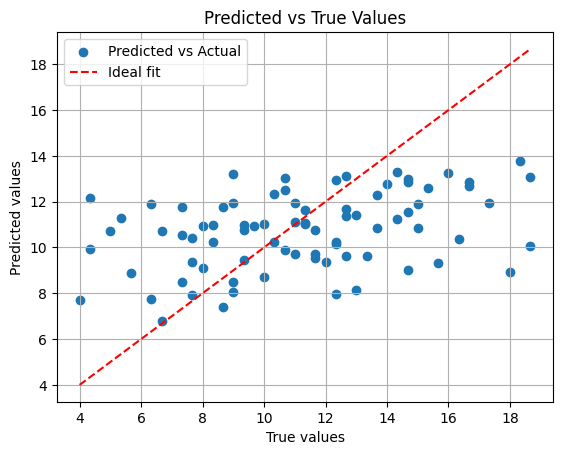

In [11]:
# Regression predicting G_avg using all features
full_dataset = pd.read_csv("Math-Students.csv", sep=",")

# Change output label to average of grades
grades = ['G1', 'G2', 'G3']
full_dataset['G_avg'] = full_dataset[grades].mean(axis=1)
full_dataset = full_dataset.drop(columns=grades)

X = full_dataset.drop("G_avg", axis=1)
X = pd.get_dummies(X, drop_first=False)  # one-hot encode categorical features
y = full_dataset["G_avg"]

rf = RandomForestRegressor(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.9, 0.8, 0.7]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.scatter(y_test, y_pred, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid(True)
plt.show()

Best params: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}

Test MSE: 13.9018
R^2 Score: -0.0665


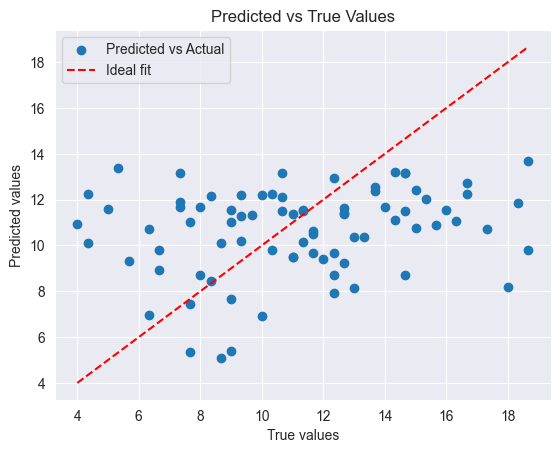

In [3]:
# Regression with simple data for web hosting
_, _, _, _, sData_X, sData_y = load_math_dataset()

rf = RandomForestRegressor(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(sData_X, sData_y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.9, 0.8, 0.7]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.scatter(y_test, y_pred, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid(True)
plt.show()